In [1]:
import nibabel as nib
from matplotlib import pyplot as plt
import os
import pickle
import numpy as np

#NN
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K

from tensorflow.python.client import device_lib

C:\Users\drago\anaconda3\envs\GWImages_2\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\drago\anaconda3\envs\GWImages_2\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\drago\anaconda3\envs\GWImages_2\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\drago\anaconda3\envs\GWImages_2\lib\site-packages

In [2]:
# Check GPU Detected
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12758118427600830656
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5090115584
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7980124942448549139
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


## Functions

In [3]:
def showImage(img, title):
    plt.imshow(img, cmap = "gray", origin = 'upper')
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.show()

In [4]:
def saveModel(directory_name, model, history):
    with open(directory_name + '_History.pkl', 'wb') as file_pi:
        pickle.dump(history, file_pi)

    model.save(directory_name + "_Model.h5")

In [5]:
#https://medium.com/@aakashgoel12/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d#:~:text=By%20default,%20f1%20score%20is%20not%20part%20of,each%20epoch,%20need%20to%20make%20some%20more%20efforts.
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [6]:
#https://stackoverflow.com/questions/39895742/matthews-correlation-coefficient-with-keras
def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

## Grouping Files into Datasets

In [7]:
base_path="C:/Users/drago/Documents/gitrepos/individual-project-alzhiemers_detection/MRI Data/WM parc data - cropped images/Blur_Contour_Crop/"

In [8]:
# Break:
# 196 : 97 : 97
# 359 : 178 : 178

In [9]:
# File setup check
print("Total training AD: ", len(os.listdir(base_path+"1-Train/AD")))
print("Total validation AD: ", len(os.listdir(base_path+"2-Validation/AD")))
print("Total testing AD: ", len(os.listdir(base_path+"3-Test/AD")))

print("\nTotal training CN: ", len(os.listdir(base_path+"1-Train/CN")))
print("Total validation CN: ", len(os.listdir(base_path+"2-Validation/CN")))
print("Total testing CN: ", len(os.listdir(base_path+"3-Test/CN")))

Total training AD:  196
Total validation AD:  97
Total testing AD:  97

Total training CN:  359
Total validation CN:  178
Total testing CN:  178


In [10]:
# Build from directory dataset generators
train_aug_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_aug_datagen = ImageDataGenerator(rescale=1./255)

train_aug_generator = train_aug_datagen.flow_from_directory(
    base_path+"1-Train/",
    target_size=(256,256),
    batch_size=32,
    class_mode="binary")

validation_aug_generator = test_aug_datagen.flow_from_directory(
    base_path+"2-Validation/",
    target_size=(256,256),
    batch_size=32,
    class_mode="binary")

Found 555 images belonging to 2 classes.
Found 275 images belonging to 2 classes.


### Data Preprosessing

In [11]:
# Check batches shape
for batch, label in train_aug_generator:
    print("data batch shape: ", batch.shape)
    print("label shape: ", label.shape)
    break

data batch shape:  (32, 256, 256, 3)
label shape:  (32,)


## Construct Model

In [12]:
# Construct model
conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(256, 256, 3))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [13]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [14]:
augmentedVGG16 = models.Sequential()
augmentedVGG16.add(conv_base)
augmentedVGG16.add(layers.Flatten())
augmentedVGG16.add(layers.Dense(256, activation='relu'))
augmentedVGG16.add(layers.Dense(1, activation='sigmoid'))
augmentedVGG16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 23,103,809
Trainable params: 23,103,809
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Freeze CNN
conv_base.trainable=False

In [16]:
# Model Compile
augmentedVGG16.compile(optimizer=optimizers.RMSprop(lr=2e-5),
                         loss='binary_crossentropy',
                         metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), get_f1, matthews_correlation])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Fitting and Saving Model

In [17]:
base_directory = "Models/VGG16_Augmented/"

In [18]:
checkpoint = ModelCheckpoint(filepath=base_directory+"checkpoints/best_model.hdf5", save_best_only=True)

# Fit model
VGG16_augmented_history = augmentedVGG16.fit_generator(
    train_aug_generator,
    steps_per_epoch=100,
    epochs=50,
    callbacks=[checkpoint],
    validation_data=validation_aug_generator,
    validation_steps=50)

VGG16_aug_history = VGG16_augmented_history.history

saveModel(base_directory + 'VGG16_aug', augmentedVGG16, VGG16_aug_history)

Epoch 1/50
100/100 [==============================] - 66s 664ms/step - loss: 0.6660 - acc: 0.6210 - precision: 0.6503 - recall: 0.8956 - get_f1: 0.7398 - matthews_correlation: 0.0337 - val_loss: 0.6181 - val_acc: 0.6541 - val_precision: 0.6527 - val_recall: 1.0000 - val_get_f1: 0.7827 - val_matthews_correlation: 0.0335
Epoch 2/50
100/100 [==============================] - 64s 636ms/step - loss: 0.6229 - acc: 0.6581 - precision: 0.6737 - recall: 0.9156 - get_f1: 0.7637 - matthews_correlation: 0.1473 - val_loss: 0.5990 - val_acc: 0.6508 - val_precision: 0.6488 - val_recall: 0.9949 - val_get_f1: 0.7806 - val_matthews_correlation: 0.0735
Epoch 3/50
100/100 [==============================] - 61s 614ms/step - loss: 0.6111 - acc: 0.6714 - precision: 0.6841 - recall: 0.9107 - get_f1: 0.7734 - matthews_correlation: 0.2018 - val_loss: 0.6145 - val_acc: 0.6853 - val_precision: 0.8433 - val_recall: 0.6350 - val_get_f1: 0.7193 - val_matthews_correlation: 0.3872
Epoch 4/50
100/100 [=================

### Retrieving Saved Model and History

In [19]:
# Get history
with open(base_directory + 'VGG16_aug_history.pkl', 'rb') as file__pi:
    VGG16_aug_history = pickle.load(file__pi)
    
# Get best model
VGG16_aug_best = models.load_model(base_directory+"checkpoints/best_model.hdf5", custom_objects={"get_f1": get_f1, "matthews_correlation": matthews_correlation})

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Plotting Results

In [23]:
accuracy = VGG16_aug_history['acc']
validation_accuracy = VGG16_aug_history['val_acc']
precision = VGG16_aug_history['precision']
validation_precision = VGG16_aug_history['val_precision']
recall = VGG16_aug_history['recall']
validation_recall = VGG16_aug_history['val_recall']
f1 = VGG16_aug_history['get_f1']
validation_f1 = VGG16_aug_history['val_get_f1']
mcc = VGG16_aug_history['matthews_correlation']
validation_mcc = VGG16_aug_history['val_matthews_correlation']

loss = VGG16_aug_history['loss']
validation_loss = VGG16_aug_history['val_loss']

epochs = range(1, len(accuracy) + 1)


train_acc:  0.80487806
train_precision:  0.81035995
train_recall:  0.9129575
train_f1:  0.8556959
train_mcc:  0.55597967
train_loss:  0.4328324180841446

valid_acc:  0.7185668
valid_precision:  0.7109783
valid_recall:  0.9548646
valid_f1:  0.8097801
valid_mcc:  0.33526948
valid_loss:  0.5858159101009369

best_acc:  0.73224753
best_precision:  0.77150786
best_recall:  0.83567137
best_f1:  0.7978437
best_mcc:  0.38521212
best_loss:  0.4977780717611313


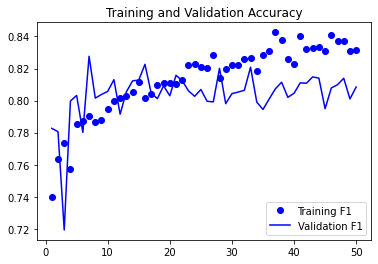

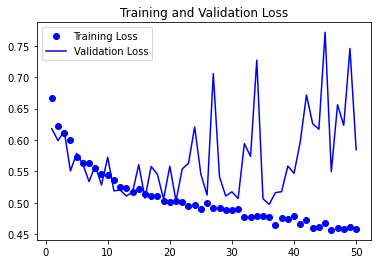

<Figure size 432x288 with 0 Axes>

In [24]:
# Accuracy Plots
plt.plot(epochs, f1, 'bo', label='Training F1')
plt.plot(epochs, validation_f1, 'b', label='Validation F1')
plt.title("Training and Validation Accuracy")
plt.legend()

plt.figure()

# Loss Plots
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.figure()

# Generate acc loss percentages
train_loss, train_acc, train_precision, train_recall, train_f1, train_mcc = augmentedVGG16.evaluate_generator(train_aug_generator, steps=50)
print("\ntrain_acc: ", train_acc)
print("train_precision: ", train_precision)
print("train_recall: ", train_recall)
print("train_f1: ", train_f1)
print("train_mcc: ", train_mcc)
print("train_loss: ", train_loss)

# Generate acc loss percentages
valid_loss, valid_acc, valid_precision, valid_recall, valid_f1, valid_mcc = augmentedVGG16.evaluate_generator(validation_aug_generator, steps=50)
print("\nvalid_acc: ", valid_acc)
print("valid_precision: ", valid_precision)
print("valid_recall: ", valid_recall)
print("valid_f1: ", valid_f1)
print("valid_mcc: ", valid_mcc)
print("valid_loss: ", valid_loss)

# Output best epoch acc loss percentages
best_loss, best_acc, best_precision, best_recall, best_f1, best_mcc = VGG16_aug_best.evaluate_generator(validation_aug_generator, steps=50)
print("\nbest_acc: ", best_acc)
print("best_precision: ", best_precision)
print("best_recall: ", best_recall)
print("best_f1: ", best_f1)
print("best_mcc: ", best_mcc)
print("best_loss: ", best_loss)

## Fine Tune

In [25]:
base_directory = "Models/VGG16_Augmented_Fine_Tune/50Epoch/"

In [26]:
checkpoint_directory = "checkpoints/"

### Set trainable higher layers

In [27]:
VGG16_aug_best.get_layer(name="vgg16").summary()
vgg16_base = VGG16_aug_best.get_layer(name="vgg16")
vgg16_base.trainable = True

set_trainable = False
for layer in vgg16_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
VGG16_aug_best.get_layer(name="vgg16").summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

### Compile and fit

In [28]:
# Model Compile
VGG16_aug_best.compile(optimizer=optimizers.RMSprop(lr=1e-5),
                         loss='binary_crossentropy',
                         metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), get_f1, matthews_correlation])

In [29]:
checkpoint = ModelCheckpoint(filepath=base_directory+checkpoint_directory+"best_model.hdf5", save_best_only=True)

# Fit model
VGG16_history = VGG16_aug_best.fit_generator(
    train_aug_generator,
    steps_per_epoch=18,
    epochs=100,
    callbacks=[checkpoint],
    validation_data=validation_aug_generator,
    validation_steps=30)

VGG16_augmented_fine_tune_history = VGG16_history.history

saveModel(base_directory + 'VGG16_aug_fine_tune', VGG16_aug_best, VGG16_augmented_fine_tune_history)

Epoch 1/100
18/18 [==============================] - 18s 980ms/step - loss: 0.6092 - acc: 0.7297 - precision_1: 0.7817 - recall_1: 0.8078 - get_f1: 0.7657 - matthews_correlation: 0.4615 - val_loss: 0.4881 - val_acc: 0.7590 - val_precision_1: 0.8145 - val_recall_1: 0.8118 - val_get_f1: 0.8149 - val_matthews_correlation: 0.4738
Epoch 2/100
18/18 [==============================] - 13s 706ms/step - loss: 0.4978 - acc: 0.7495 - precision_1: 0.7865 - recall_1: 0.8412 - get_f1: 0.7939 - matthews_correlation: 0.4498 - val_loss: 0.4975 - val_acc: 0.7340 - val_precision_1: 0.7636 - val_recall_1: 0.8521 - val_get_f1: 0.8002 - val_matthews_correlation: 0.3853
Epoch 3/100
18/18 [==============================] - 13s 706ms/step - loss: 0.4856 - acc: 0.7802 - precision_1: 0.8110 - recall_1: 0.8607 - get_f1: 0.8311 - matthews_correlation: 0.5211 - val_loss: 0.8760 - val_acc: 0.6667 - val_precision_1: 0.6596 - val_recall_1: 0.9949 - val_get_f1: 0.7893 - val_matthews_correlation: 0.1542
Epoch 4/100
18/1

Epoch 26/100
18/18 [==============================] - 14s 781ms/step - loss: 0.4253 - acc: 0.7874 - precision_1: 0.8179 - recall_1: 0.8635 - get_f1: 0.8378 - matthews_correlation: 0.5292 - val_loss: 0.5001 - val_acc: 0.7318 - val_precision_1: 0.8534 - val_recall_1: 0.7095 - val_get_f1: 0.7680 - val_matthews_correlation: 0.4593
Epoch 27/100
18/18 [==============================] - 14s 798ms/step - loss: 0.4341 - acc: 0.7892 - precision_1: 0.8270 - recall_1: 0.8524 - get_f1: 0.8296 - matthews_correlation: 0.5612 - val_loss: 0.4677 - val_acc: 0.7731 - val_precision_1: 0.8252 - val_recall_1: 0.8238 - val_get_f1: 0.8190 - val_matthews_correlation: 0.5039
Epoch 28/100
18/18 [==============================] - 15s 826ms/step - loss: 0.4179 - acc: 0.8234 - precision_1: 0.8443 - recall_1: 0.8914 - get_f1: 0.8699 - matthews_correlation: 0.6168 - val_loss: 0.5064 - val_acc: 0.7600 - val_precision_1: 0.7629 - val_recall_1: 0.9147 - val_get_f1: 0.8259 - val_matthews_correlation: 0.4354
Epoch 29/100


Epoch 51/100
18/18 [==============================] - 15s 812ms/step - loss: 0.3374 - acc: 0.8559 - precision_1: 0.8720 - recall_1: 0.9109 - get_f1: 0.8932 - matthews_correlation: 0.7122 - val_loss: 0.5175 - val_acc: 0.7503 - val_precision_1: 0.7570 - val_recall_1: 0.9044 - val_get_f1: 0.8170 - val_matthews_correlation: 0.4333
Epoch 52/100
18/18 [==============================] - 15s 814ms/step - loss: 0.3207 - acc: 0.8505 - precision_1: 0.8710 - recall_1: 0.9025 - get_f1: 0.8858 - matthews_correlation: 0.6826 - val_loss: 0.5320 - val_acc: 0.7459 - val_precision_1: 0.7595 - val_recall_1: 0.8935 - val_get_f1: 0.8185 - val_matthews_correlation: 0.4191
Epoch 53/100
18/18 [==============================] - 15s 808ms/step - loss: 0.3856 - acc: 0.8360 - precision_1: 0.8641 - recall_1: 0.8858 - get_f1: 0.8734 - matthews_correlation: 0.6667 - val_loss: 0.4736 - val_acc: 0.7503 - val_precision_1: 0.7766 - val_recall_1: 0.8648 - val_get_f1: 0.8119 - val_matthews_correlation: 0.4112
Epoch 54/100


Epoch 76/100
18/18 [==============================] - 15s 809ms/step - loss: 0.2983 - acc: 0.8775 - precision_1: 0.8965 - recall_1: 0.9164 - get_f1: 0.9091 - matthews_correlation: 0.7261 - val_loss: 0.5194 - val_acc: 0.7666 - val_precision_1: 0.7723 - val_recall_1: 0.9039 - val_get_f1: 0.8301 - val_matthews_correlation: 0.4626
Epoch 77/100
18/18 [==============================] - 15s 815ms/step - loss: 0.3159 - acc: 0.8432 - precision_1: 0.8820 - recall_1: 0.8747 - get_f1: 0.8818 - matthews_correlation: 0.6839 - val_loss: 1.0033 - val_acc: 0.6992 - val_precision_1: 0.6829 - val_recall_1: 0.9949 - val_get_f1: 0.8088 - val_matthews_correlation: 0.2907
Epoch 78/100
18/18 [==============================] - 15s 807ms/step - loss: 0.3375 - acc: 0.8378 - precision_1: 0.8645 - recall_1: 0.8886 - get_f1: 0.8718 - matthews_correlation: 0.6521 - val_loss: 0.6379 - val_acc: 0.7372 - val_precision_1: 0.7329 - val_recall_1: 0.9420 - val_get_f1: 0.8188 - val_matthews_correlation: 0.3929
Epoch 79/100


### Retrieving Saved Model and History

In [30]:
with open(base_directory + 'VGG16_aug_fine_tune_history.pkl', 'rb') as file__pi:
    VGG16_augmented_fine_tune_history = pickle.load(file__pi)
    
VGG16_augmented_fine_tune_best = models.load_model(base_directory+checkpoint_directory+"best_model.hdf5", 
                                                   custom_objects={"get_f1": get_f1, "matthews_correlation": matthews_correlation})

### Plotting Results

In [34]:
accuracy = VGG16_augmented_fine_tune_history['acc']
validation_accuracy = VGG16_augmented_fine_tune_history['val_acc']
precision = VGG16_augmented_fine_tune_history['precision_1']
validation_precision = VGG16_augmented_fine_tune_history['val_precision_1']
recall = VGG16_augmented_fine_tune_history['recall_1']
validation_recall = VGG16_augmented_fine_tune_history['val_recall_1']
f1 = VGG16_augmented_fine_tune_history['get_f1']
validation_f1 = VGG16_augmented_fine_tune_history['val_get_f1']
mcc = VGG16_augmented_fine_tune_history['matthews_correlation']
validation_mcc = VGG16_augmented_fine_tune_history['val_matthews_correlation']

loss = VGG16_augmented_fine_tune_history['loss']
validation_loss = VGG16_augmented_fine_tune_history['val_loss']

epochs = range(1, len(accuracy) + 1)


train_acc:  0.87612325
train_precision:  0.8471392
train_recall:  0.9860835
train_f1:  0.9068385
train_mcc:  0.72619283
train_loss:  0.2899986620247364

valid_acc:  0.71921825
valid_precision:  0.7098214
valid_recall:  0.958794
valid_f1:  0.81439424
valid_mcc:  0.331728
valid_loss:  0.8169169610738755

best_acc:  0.7752443
best_precision:  0.7869718
best_recall:  0.8966901
best_f1:  0.834138
best_mcc:  0.47878867
best_loss:  0.4584007874131203


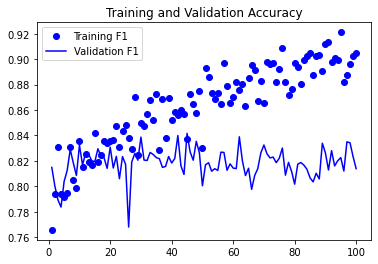

<Figure size 432x288 with 0 Axes>

In [35]:
# Accuracy Plots
plt.plot(epochs, f1, 'bo', label='Training F1')
plt.plot(epochs, validation_f1, 'b', label='Validation F1')
plt.title("Training and Validation Accuracy")
plt.legend()

plt.figure()

# Loss Plots
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.figure()

# Generate acc loss percentages
train_loss, train_acc, train_precision, train_recall, train_f1, train_mcc = VGG16_aug_best.evaluate_generator(train_aug_generator, steps=50)
print("\ntrain_acc: ", train_acc)
print("train_precision: ", train_precision)
print("train_recall: ", train_recall)
print("train_f1: ", train_f1)
print("train_mcc: ", train_mcc)
print("train_loss: ", train_loss)

# Generate acc loss percentages
valid_loss, valid_acc, valid_precision, valid_recall, valid_f1, valid_mcc = VGG16_aug_best.evaluate_generator(validation_aug_generator, steps=50)
print("\nvalid_acc: ", valid_acc)
print("valid_precision: ", valid_precision)
print("valid_recall: ", valid_recall)
print("valid_f1: ", valid_f1)
print("valid_mcc: ", valid_mcc)
print("valid_loss: ", valid_loss)

# Output best epoch acc loss percentages
best_loss, best_acc, best_precision, best_recall, best_f1, best_mcc = VGG16_augmented_fine_tune_best.evaluate_generator(validation_aug_generator, steps=50)
print("\nbest_acc: ", best_acc)
print("best_precision: ", best_precision)
print("best_recall: ", best_recall)
print("best_f1: ", best_f1)
print("best_mcc: ", best_mcc)
print("best_loss: ", best_loss)